# Simple Reinforcement Learning with Tensorflow

## Part 0: Q-Learning with Tables and Neural Networks
- https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0

In [3]:
import gym
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
env = gym.make('FrozenLake-v0')

[2017-11-30 09:59:19,616] Making new env: FrozenLake-v0


In [5]:
env

<TimeLimit<FrozenLakeEnv<FrozenLake-v0>>>

In [6]:
tf.reset_default_graph()

In [7]:
inputs1 = tf.placeholder(shape=[1, 16], dtype=tf.float32)
W = tf.Variable(tf.random_uniform([16, 4], 0, 0.01))
Qout = tf.matmul(inputs1, W)
predict = tf.argmax(Qout, 1)

In [8]:
Qout

<tf.Tensor 'MatMul:0' shape=(1, 4) dtype=float32>

In [9]:
nextQ = tf.placeholder(shape=[1, 4], dtype=tf.float32)
loss = tf.reduce_sum(tf.square(nextQ - Qout))
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
updateModel = trainer.minimize(loss)

In [10]:
init = tf.global_variables_initializer()

In [11]:
y = 0.99
e = 0.1
num_episodes = 2000

jList = []
rList = []

with tf.Session() as sess:
    sess.run(init)
    for i in range(num_episodes):
        s = env.reset()
        rAll = 0
        d = False
        j = 0
        while j < 99:
            j += 1
            # 1-of-Kで状態を入力してQ-value（入力した状態において各行動をとったときの価値）
            # と取るべき行動（最大のQ値を持つ行動）を選択
            a, allQ = sess.run([predict, Qout], feed_dict={inputs1: np.identity(16)[s:s+1]})
            # e-greedy
            if np.random.rand(1) < e:
                a[0] = env.action_space.sample()
            s1, r, d, _ = env.step(a[0])
            # 次の状態s1での各行動の価値をNNで計算
            Q1 = sess.run(Qout, feed_dict={inputs1: np.identity(16)[s1:s1+1]})
            maxQ1 = np.max(Q1)  # 次の状態s'で最大の価値 max(Q(s', a'))
            targetQ = allQ      # 前の状態sでの各行動の価値
            targetQ[0, a[0]] = r + y * maxQ1
            _, W1 = sess.run([updateModel, W],
                             feed_dict={inputs1: np.identity(16)[s:s + 1], nextQ: targetQ})
            rAll += r
            s = s1
            if d:
                e = 1.0 / ((i / 50) + 10)
                break
        jList.append(j)
        rList.append(rAll)
print('Percent of successful episodes:' + str(sum(rList) / num_episodes) + '%')

Percent of successful episodes:0.511%


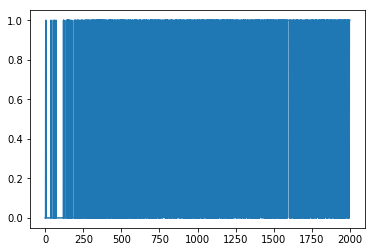

In [12]:
plt.plot(rList)

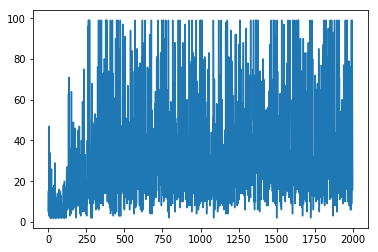

In [13]:
plt.plot(jList)

## Part 1 - Two-armed Bandit

- https://medium.com/@awjuliani/super-simple-reinforcement-learning-tutorial-part-1-fd544fab149

In [14]:
import tensorflow as tf
import numpy as np

In [15]:
# indexの大きい腕ほど positive reward 得やすい設定
bandits = [0.2, 0.0, -0.2, -5.0]
num_bandits = len(bandits)
def pullBandit(bandit):
    result = np.random.randn(1)
    if result > bandit:
        return 1
    else:
        return -1

In [16]:
tf.reset_default_graph()

In [17]:
weights = tf.Variable(tf.ones([num_bandits]))
chosen_action = tf.argmax(weights, 0)

In [18]:
reward_holder = tf.placeholder(shape=[1],dtype=tf.float32)
action_holder = tf.placeholder(shape=[1],dtype=tf.int32)
# 選択した行動に対応する重みのみ取り出す
responsible_weight = tf.slice(weights, action_holder, [1])
# 報酬を得られる腕の重み（選択確率）が高いほどlossが小さくなる設定
loss = - (tf.log(responsible_weight) * reward_holder)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
update = optimizer.minimize(loss)

In [19]:
total_episodes = 1000
total_reward = np.zeros(num_bandits)
e = 0.1

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    i = 0
    while i < total_episodes:
        # e-greedy
        if np.random.rand(1) < e:
            action = np.random.randint(num_bandits)
        else:
            action = sess.run(chosen_action)

        reward = pullBandit(bandits[action])
        
        # policy gradient
        _, resp, ww = sess.run([update, responsible_weight, weights],
                               feed_dict={reward_holder: [reward], action_holder: [action]})
        
        total_reward[action] += reward
        if i % 50 == 0:
            print('Running reward for the ' + str(num_bandits) + ' bandits: ' + str(total_reward))
        i += 1

print('The agent thinks bandit ' + str(np.argmax(ww) + 1) + ' is the most promissing...')

if np.argmax(ww) == np.argmax(-np.array(bandits)):
    print('... and it was right!')
else:
    print('... and it was wrong!')

Running reward for the 4 bandits: [ 1.  0.  0.  0.]
Running reward for the 4 bandits: [ 5. -1. -1.  2.]
Running reward for the 4 bandits: [  1.  -3.   0.  35.]
Running reward for the 4 bandits: [  1.  -3.   1.  78.]
Running reward for the 4 bandits: [  -1.   -3.    2.  125.]
Running reward for the 4 bandits: [  -2.   -2.    1.  172.]
Running reward for the 4 bandits: [  -3.   -2.    2.  220.]
Running reward for the 4 bandits: [  -2.   -1.    3.  267.]
Running reward for the 4 bandits: [  -5.    1.    1.  308.]
Running reward for the 4 bandits: [  -4.    0.    0.  353.]
Running reward for the 4 bandits: [  -3.   -2.    1.  399.]
Running reward for the 4 bandits: [  -2.   -2.    0.  447.]
Running reward for the 4 bandits: [  -2.   -3.    0.  496.]
Running reward for the 4 bandits: [  -4.   -3.    0.  544.]
Running reward for the 4 bandits: [  -5.   -2.    1.  589.]
Running reward for the 4 bandits: [  -5.   -2.    1.  637.]
Running reward for the 4 bandits: [  -5.    0.    0.  680.]
Runn

## Part 1.5: Contextual Bandits

- https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-1-5-contextual-bandits-bff01d1aad9c

In [20]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import numpy as np

In [21]:
class contextual_bandit():
    def __init__(self):
        self.state = 0
        #List out our bandits. Currently arms 4, 2, and 1 (respectively) are the most optimal.
        self.bandits = np.array([[0.2,0,-0.0,-5], [0.1,-5,1,0.25], [-5,5,5,5]])
        self.num_bandits = self.bandits.shape[0]
        self.num_actions = self.bandits.shape[1]

    def getBandit(self):
        # ランダムにbanditを選択
        self.state = np.random.randint(0, len(self.bandits))
        return self.state

    def pullArm(self, action):
        #Get a random number.
        bandit = self.bandits[self.state, action]
        result = np.random.randn(1)
        if result > bandit:
            #return a positive reward.
            return 1
        else:
            #return a negative reward.
            return -1

In [22]:
class agent():
    def __init__(self, lr, s_size, a_size):
        self.state_in = tf.placeholder(shape=[1], dtype=tf.int32)
        state_in_OH = slim.one_hot_encoding(self.state_in, s_size)
        output = slim.fully_connected(state_in_OH, a_size,
                                      biases_initializer=None,
                                      activation_fn=tf.nn.sigmoid,
                                      weights_initializer=tf.ones_initializer())
        self.output = tf.reshape(output, [-1])
        self.chosen_action = tf.argmax(self.output, 0)
        
        self.reward_holder = tf.placeholder(shape=[1], dtype=tf.float32)
        self.action_holder = tf.placeholder(shape=[1], dtype=tf.int32)
        self.responsible_weight = tf.slice(self.output, self.action_holder, [1])
        self.loss = - (tf.log(self.responsible_weight) * self.reward_holder)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
        self.update = optimizer.minimize(self.loss)

In [23]:
tf.reset_default_graph()

In [24]:
cBandit = contextual_bandit()
myAgent = agent(lr=0.001, s_size=cBandit.num_bandits, a_size=cBandit.num_actions)
weights = tf.trainable_variables()[0]

In [25]:
total_episodes = 10000
total_reward = np.zeros([cBandit.num_bandits, cBandit.num_actions])
e = 0.1

In [30]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    i = 0
    while i < total_episodes:
        # 各エピソードでランダムにbandit（状態）を選択
        s = cBandit.getBandit()
        
        if np.random.rand(1) < e:
            action = np.random.randint(cBandit.num_actions)
        else:
            action = sess.run(myAgent.chosen_action, feed_dict={myAgent.state_in:[s]})
        
        reward = cBandit.pullArm(action)
        
        feed_dict = {myAgent.reward_holder: [reward],
                     myAgent.action_holder: [action],
                     myAgent.state_in: [s]}
        _, ww = sess.run([myAgent.update, weights], feed_dict=feed_dict)
        
        total_reward[s, action] += reward
        if i % 500 == 0:
            print("Mean reward for each of the " + str(cBandit.num_bandits) + " bandits: " + str(np.mean(total_reward, axis=1)))
        i += 1

Mean reward for each of the 3 bandits: [ 775.25  758.75  694.25]
Mean reward for each of the 3 bandits: [ 809.    797.    734.75]
Mean reward for each of the 3 bandits: [ 845.    835.75  772.  ]
Mean reward for each of the 3 bandits: [ 882.5   874.25  805.5 ]
Mean reward for each of the 3 bandits: [ 918.25  914.5   841.5 ]
Mean reward for each of the 3 bandits: [ 961.75  951.25  874.75]
Mean reward for each of the 3 bandits: [ 1001.5    990.     906.75]
Mean reward for each of the 3 bandits: [ 1041.75  1029.5    941.  ]
Mean reward for each of the 3 bandits: [ 1080.5   1067.25   980.  ]
Mean reward for each of the 3 bandits: [ 1123.    1100.5   1016.75]
Mean reward for each of the 3 bandits: [ 1164.25  1138.5   1051.5 ]
Mean reward for each of the 3 bandits: [ 1205.25  1175.    1085.5 ]
Mean reward for each of the 3 bandits: [ 1246.    1205.5   1121.75]
Mean reward for each of the 3 bandits: [ 1286.    1243.    1158.75]
Mean reward for each of the 3 bandits: [ 1321.5   1285.25  1193.5 

In [31]:
ww.shape

(3, 4)

In [34]:
ww  # 各状態・行動のQテーブル

array([[ 0.99488294,  1.00027025,  1.00134647,  1.64070892],
       [ 1.00054002,  1.64443779,  0.98703176,  0.99488282],
       [ 1.6431421 ,  0.98104542,  0.97640234,  0.98268032]], dtype=float32)

In [35]:
# 各状態（bandit）で最大のQ値を持つ行動を返す
for s in range(cBandit.num_bandits):
    print("The agent thinks action " + str(np.argmax(ww[s])+1) + " for bandit " + str(s+1) + " is the most promising....")
    if np.argmax(ww[s]) == np.argmin(cBandit.bandits[s]):
        print("...and it was right!")
    else:
        print("...and it was wrong!")

The agent thinks action 4 for bandit 1 is the most promising....
...and it was right!
The agent thinks action 2 for bandit 2 is the most promising....
...and it was right!
The agent thinks action 1 for bandit 3 is the most promising....
...and it was right!


## Part 2 - Policy-based Agents

- https://medium.com/@awjuliani/super-simple-reinforcement-learning-tutorial-part-2-ded33892c724

In [38]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import numpy as np
import gym
import matplotlib.pyplot as plt
%matplotlib inline

In [39]:
env = gym.make('CartPole-v0')

[2017-11-30 10:09:27,039] Making new env: CartPole-v0


In [50]:
gamma = 0.99

def discount_rewards(r):
    """1次元の報酬配列を受け取って累積割引報酬を返す"""
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, r.size)):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

In [51]:
r = np.array([1.0, 1.0, 1.0])
discount_rewards(r)

array([ 2.9701,  1.99  ,  1.    ])

In [52]:
class agent():
    def __init__(self, lr, s_size, a_size, h_size):
        # 状態 => 各行動のQ値へのニューラルネット
        self.state_in = tf.placeholder(shape=[None, s_size], dtype=tf.float32)
        hidden = slim.fully_connected(self.state_in, h_size,
                                      biases_initializer=None,
                                      activation_fn=tf.nn.relu)
        self.output = slim.fully_connected(hidden, a_size,
                                           activation_fn=tf.nn.softmax,
                                           biases_initializer=None)
        # Q値のもっとも高い行動を選択
        self.chosen_action = tf.argmax(self.output, 1)
        
        self.reward_holder = tf.placeholder(shape=[None], dtype=tf.float32)
        self.action_holder = tf.placeholder(shape=[None], dtype=tf.int32)